In [1]:
!pip install hazm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 16.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 58.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires 

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from hazm import Normalizer, word_tokenize, stopwords_list
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from gensim.models.fasttext import FastText
import matplotlib.pyplot as plt
import numpy as np

### Read data from Excel file without headers

In [3]:
df = pd.read_excel('/kaggle/input/content/train_data.xlsx', header=None)
df.columns = ['Text', 'Emotion']

### Apply normalizer to the text

In [5]:
normalizer = Normalizer()
df['Text'] = df['Text'].apply(normalizer.normalize)

### Text augmentation function

In [7]:
def augment_text(text):
    words = word_tokenize(text)
    if len(words) > 1:
        augmentedtxts = []
        np.random.shuffle(words)
        augmentedtxts.append(' '.join(words))
        return augmentedtxts
    return [text]

### Apply text augmentation

In [8]:
augmenteddf = []
for _, row in df.iterrows():
    text = row['Text']
    emotion = row['Emotion']
    augmentedtxts = augment_text(text)
    for aug_text in augmentedtxts:
        augmenteddf.append([aug_text, emotion])
augmented_df = pd.DataFrame(augmenteddf, columns=['Text', 'Emotion'])

# Combine original and augmented data
df = pd.concat([df, augmented_df]).reset_index(drop=True)

### Train fastText model on the text corpus

In [9]:
corpus = [word_tokenize(text) for text in df['Text']]
ft_model = FastText(sentences=corpus, vector_size=100, window=5, min_count=1, sg=1)

### Transform texts to vectors using fastText embeddings

In [10]:
def fasttext_vectorizer(text):
    tokens = word_tokenize(text)
    vector = []
    for token in tokens:
        if token in ft_model.wv:
            vector.append(ft_model.wv[token])
    return sum(vector) / len(vector) if vector else [0] * 100

### Create a combined vectorizer class

In [11]:
class CombinedVectorizer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [fasttext_vectorizer(text) for text in X]

combined_vectorizer = CombinedVectorizer()

### Create the  Random Forest

In [12]:
rf_classifier = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200
)

ada_classifier = AdaBoostClassifier(random_state=42)
gb_classifier = GradientBoostingClassifier(random_state=42)
svm_classifier = SVC(probability=True, random_state=42)

### Create an ensemble model using VotingClassifier

In [13]:
ensemble_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('ada', ada_classifier),
        ('gb', gb_classifier),
        ('svm', svm_classifier)
    ],
    voting='soft'
)

pipeline = Pipeline([
    ('vectorizer', combined_vectorizer),
    ('classifier', ensemble_classifier)
])

### Encode labels properly for the classifier

In [14]:
label_encoder = LabelEncoder()
df['Emotion'] = label_encoder.fit_transform(df['Emotion'])

### Split data

In [15]:
X = df['Text']
y = df['Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Cross-validation to track accuracy over multiple folds

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_scores = []
test_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train_cv, y_train_cv)
    train_scores.append(pipeline.score(X_train_cv, y_train_cv))
    test_scores.append(pipeline.score(X_test_cv, y_test_cv))

### Plot training and test accuracy

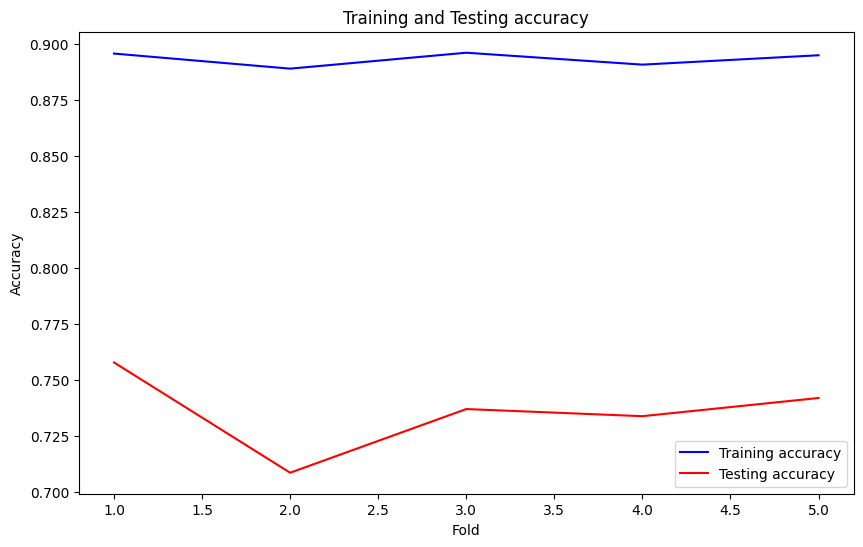

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), train_scores, 'b', label='Training accuracy')
plt.plot(range(1, 6), test_scores, 'r', label='Testing accuracy')
plt.title('Training and Testing accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Fit the ensemble model on the full training data and evaluate

In [19]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       ANGRY       0.85      0.62      0.72       327
        FEAR       0.65      0.33      0.44        94
       HAPPY       0.87      0.81      0.84       436
       OTHER       0.59      0.90      0.72       363
         SAD       0.76      0.69      0.73       258

    accuracy                           0.74      1478
   macro avg       0.74      0.67      0.69      1478
weighted avg       0.76      0.74      0.74      1478



### Plot confusion matrix

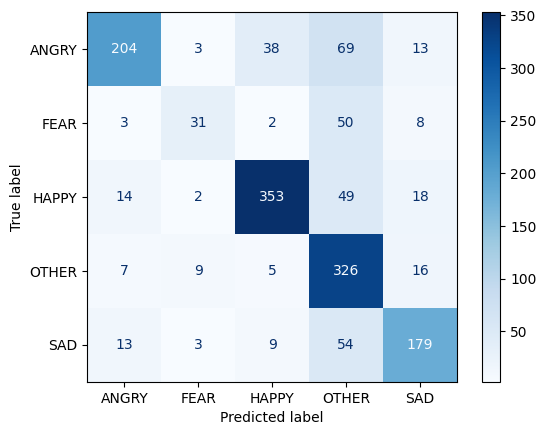

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Evaluate on new dataset

In [21]:
new_df = pd.read_csv('/kaggle/input/testing/3rdHW_test.csv', header=None)
new_df.columns = ['Text']
new_df['Text'] = new_df['Text'].apply(normalizer.normalize)

X_new = new_df['Text']
y_new_pred = pipeline.predict(X_new)

### Create a new DataFrame with the original texts and their predicted labels

In [22]:
results_df = pd.DataFrame({
    'X': new_df['Text'],
    'Y': label_encoder.inverse_transform(y_new_pred)
})

### Save the results to a new CSV file

In [24]:
results_df.to_csv('predictions.csv', index=False)

print(results_df.head())

                                                   X      Y
0               صعب روزی، بوالعجب کاری، پریشان عالمی  OTHER
1         بسیار نرم و لطیف بوده و کیفیت بالایی داره.  HAPPY
2      اصلا رنگش با چیزی که تو عکس بود خیلی فرق داشت  ANGRY
3            خیلی زیبا و ب اندازه و با دقت طراحی‌شده  HAPPY
4  سبزی‌پلو با ماهی مال عید نوروزه، امشب سوشی می‌...  OTHER
